# Term Project Machine Learning

### Import Libraries

In [904]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
sns.set()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

### Load Data

In [905]:
#load data
df = pd.read_csv('../data/spotify-2023.csv',encoding='latin-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6


### Clean Data

In [906]:
df_copy = df.copy()

In [907]:
df_copy.isnull().sum()

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

In [908]:
df_copy.dropna(inplace=True)

In [909]:
df_copy.isnull().sum()

track_name              0
artist(s)_name          0
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
in_deezer_playlists     0
in_deezer_charts        0
in_shazam_charts        0
bpm                     0
key                     0
mode                    0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64

In [910]:
df_copy.describe()


,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000
mean,1.567931,2018.457772,6.018360,13.696450,4849.898409,11.722154,60.161567,49.473684,2.451652,122.565483,67.391677,51.201958,64.362301,26.309670,1.676867,18.168911,10.526316
std,0.876211,10.829267,3.572554,9.299663,7741.126455,18.617668,74.923594,49.570455,5.397024,28.174803,14.688458,23.620978,16.107587,25.470972,8.767328,13.541996,10.219987
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.000000,4.000000,14.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2021.000000,3.000000,5.000000,829.000000,0.000000,12.000000,6.000000,0.000000,99.000000,57.000000,32.000000,53.000000,5.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,5.000000,13.000000,2040.000000,3.000000,32.000000,34.000000,0.000000,120.000000,70.000000,51.000000,66.000000,17.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,4890.000000,16.000000,78.000000,84.000000,2.000000,141.000000,79.000000,70.000000,76.000000,41.000000,0.000000,24.000000,12.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,532.000000,275.000000,45.000000,206.000000,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


In [911]:

num_rows = df_copy.shape[0]

# Print the number of rows
print(num_rows)

# Iterate over column names
for column in df_copy.columns:
    # Convert each column to float
   df_copy[column] = pd.to_numeric(df_copy[column], errors='coerce').astype(float)


# Display DataFrame information
df_copy.info()



817
<class 'pandas.core.frame.DataFrame'>
Int64Index: 817 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            5 non-null      float64
 1   artist(s)_name        0 non-null      float64
 2   artist_count          817 non-null    float64
 3   released_year         817 non-null    float64
 4   released_month        817 non-null    float64
 5   released_day          817 non-null    float64
 6   in_spotify_playlists  817 non-null    float64
 7   in_spotify_charts     817 non-null    float64
 8   streams               816 non-null    float64
 9   in_apple_playlists    817 non-null    float64
 10  in_apple_charts       817 non-null    float64
 11  in_deezer_playlists   752 non-null    float64
 12  in_deezer_charts      817 non-null    float64
 13  in_shazam_charts      813 non-null    float64
 14  bpm                   817 non-null    float64
 15  key                

In [912]:
# #pd.options.display.max_columns = 24

# # Display the DataFrame information
# # df_copy['streams'].astype(float)
# #df_copy['streams'] = df_copy['streams'].astype(float)

# # Remove commas and convert to float
# df_copy['streams'] = pd.to_numeric(df_copy['streams'], errors='coerce').astype(float)



In [913]:
df_copy['streams'].info

<bound method Series.info of 0      1.413817e+08
1      1.337163e+08
2      1.400040e+08
3      8.008408e+08
4      3.032363e+08
5      1.837062e+08
6      7.259801e+08
7      5.814938e+07
8      9.521732e+07
9      5.536341e+08
10     5.056714e+08
11     5.825515e+07
13     3.875707e+08
15     1.163094e+09
16     4.967957e+08
18     3.352222e+08
19     3.633697e+08
20     8.644484e+07
21     5.213525e+07
23     2.006472e+08
24     1.153646e+08
25     7.830065e+07
26     8.991834e+08
27     6.124529e+07
28     4.298298e+08
29     1.274090e+08
30     2.258116e+07
31     5.229427e+07
32     8.439575e+08
33     9.997483e+08
34     6.189904e+08
36     1.889335e+08
37     1.355959e+09
38     7.861818e+08
39     1.765535e+08
40     3.544954e+08
41     2.808097e+09
42     1.109433e+09
43     1.047101e+09
45     5.705151e+08
47     1.647990e+09
48     2.565530e+09
49     5.187451e+08
50     1.077538e+08
51     1.777407e+08
52     1.533720e+08
53     5.787644e+07
56     2.564834e+08
57     1.21

In [914]:
df_copy.describe()

c:\Users\sandy\anaconda3\lib\site-packages\numpy\lib\function_base.py:4529: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,5.0,0.0,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,8.160000e+02,817.000000,817.000000,752.000000,817.000000,813.000000,817.000000,0.0,0.0,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000,817.000000
mean,inf,NaN,1.567931,2018.457772,6.018360,13.696450,4849.898409,11.722154,4.689858e+08,60.161567,49.473684,93.492021,2.451652,51.691267,122.565483,NaN,NaN,67.391677,51.201958,64.362301,26.309670,1.676867,18.168911,10.526316
std,NaN,NaN,0.876211,10.829267,3.572554,9.299663,7741.126455,18.617668,5.231267e+08,74.923594,49.570455,155.561951,5.397024,128.746914,28.174803,NaN,NaN,14.688458,23.620978,16.107587,25.470972,8.767328,13.541996,10.219987
min,69.0,NaN,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,2.762000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,NaN,NaN,23.000000,4.000000,14.000000,0.000000,0.000000,3.000000,2.000000
25%,212.0,NaN,1.000000,2021.000000,3.000000,5.000000,829.000000,0.000000,1.342848e+08,12.000000,6.000000,12.000000,0.000000,0.000000,99.000000,NaN,NaN,57.000000,32.000000,53.000000,5.000000,0.000000,10.000000,4.000000
50%,295.0,NaN,1.000000,2022.000000,5.000000,13.000000,2040.000000,3.000000,2.638368e+08,32.000000,34.000000,32.000000,0.000000,2.000000,120.000000,NaN,NaN,70.000000,51.000000,66.000000,17.000000,0.000000,12.000000,6.000000
75%,NaN,NaN,2.000000,2022.000000,9.000000,22.000000,4890.000000,16.000000,6.011986e+08,78.000000,84.000000,99.000000,2.000000,37.000000,141.000000,NaN,NaN,79.000000,70.000000,76.000000,41.000000,0.000000,24.000000,12.000000
max,inf,NaN,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,3.562544e+09,532.000000,275.000000,964.000000,45.000000,953.000000,206.000000,NaN,NaN,96.000000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


In [915]:
df_sorted = df_copy.sort_values(by='streams', ascending=False)

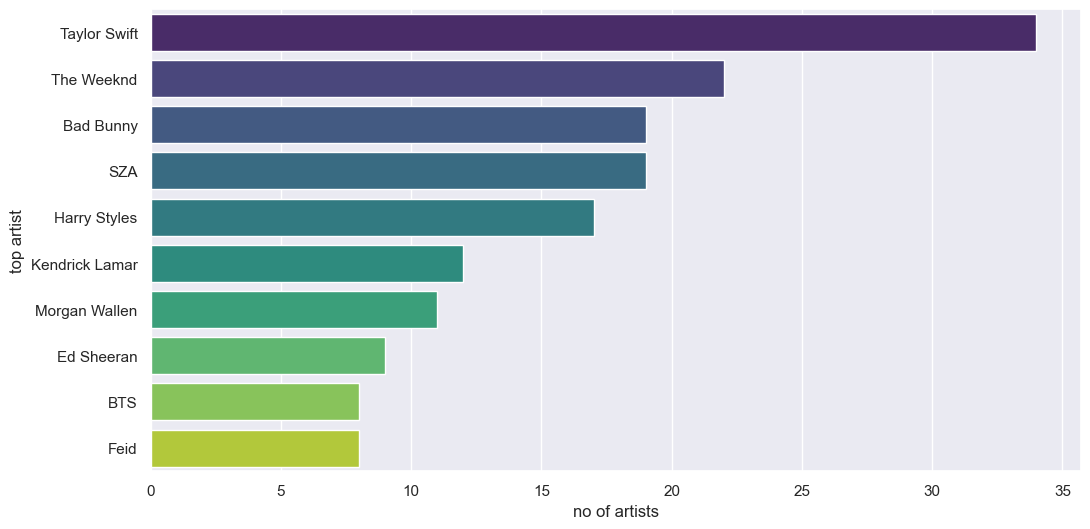

In [916]:
# Assuming you have your DataFrame 'top_10_streamed' prepared correctly
artist_name = df['artist(s)_name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=artist_name.values, y=artist_name.index, palette='viridis')
plt.xlabel('no of artists')
plt.ylabel('top artist')
plt.show()  # Display the plot

In [917]:
artist_name

Taylor Swift      34
The Weeknd        22
Bad Bunny         19
SZA               19
Harry Styles      17
Kendrick Lamar    12
Morgan Wallen     11
Ed Sheeran         9
BTS                8
Feid               8
Name: artist(s)_name, dtype: int64

In [918]:
target = df_copy['streams']
inputs = df_copy[['artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists',
               'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
               'in_deezer_charts', 'in_shazam_charts', 'bpm', 'mode', 'danceability_%',
               'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%',
               'speechiness_%']]

In [919]:
scaler = StandardScaler()
scaler.fit(inputs)

c:\Users\sandy\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\sandy\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\sandy\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


StandardScaler()

In [920]:
inputs_scaled = scaler.transform(inputs)

In [921]:
x_train,x_test,y_train,y_test = train_test_split(inputs_scaled,target,test_size=0.2,random_state=365)

In [922]:
reg = LinearRegression()

In [923]:
# Check for missing values in X_train
print(X_train.isnull().sum())


artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
in_apple_playlists      0
in_apple_charts         0
in_deezer_playlists     0
in_deezer_charts        0
in_shazam_charts        0
bpm                     0
key                     0
mode                    0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64


In [924]:


# Create an imputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on X_train
X_train_imputed = imputer.fit_transform(X_train)

# If you're testing the model on a separate set (X_test), also impute missing values in X_test
X_test_imputed = imputer.transform(X_test)


ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: '6,720'

In [ ]:
reg.fit(x_train,y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:


# # Assume 'popularity' is the target variable and 'feature1', 'feature2', etc., are your features
# features = df_copy[['artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists',
#                'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists',
#                'in_deezer_charts', 'in_shazam_charts', 'bpm', 'key', 'mode', 'danceability_%',
#                'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%',
#                'speechiness_%']]

# target = df_copy['streams']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Create and train a linear regression model
# model = LinearRegression()
# model.fit(X_train_scaled, y_train)

# # Make predictions on the test set
# predictions = model.predict(X_test_scaled)

# # Evaluate the model
# mse = mean_squared_error(y_test, predictions)
# print(f'Mean Squared Error: {mse}')

# # Now, you can use the trained model for predictions on new data.
